# Lab 10 -- Decision Trees for Regression

Compared to last week, this is a very simple lab <span style="font-size:20pt;">😃</span> You'll have fun programming!

You will implement the **Classification and Regression Tree (CART)** algorithm from scratch.

The lab is broken down into the following pieces:

* Regression Criterion
* Creating Splits
* Buiding a Tree
* Making a prediction

## Exercise 1 -- Download and load the dataset

We will be using the usual Boston Housing dataset, which is available to download from ECLASS

* Download the file
* Read it and separate the target variable from the features.
* Make a 80/10/10 train/validation/test split

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# your code here
boston = pd.read_csv('BostonHousing.txt')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


The target variable will be as usual `MEDV`. Use the rest as features.

In [3]:
# your code here
x, t = boston.values[:, :-1], boston.values[:, -1]

x_train, x_temp, t_train, t_temp = train_test_split(x, t, train_size = 0.7)
x_valid, x_test, t_valid, t_test = train_test_split(x_temp, t_temp, train_size = 0.5)

## Exercise 2 -- Optimization Criterion

For regression, a simple criterion to optimize is to minimize the sum of squared errors for a given region. This is, for all datapoints in a region with size, we minimize:

$$\sum_{i=1}^N(y_i - \hat{y})^2$$

where $N$ is the number of datapoits in the region and $\hat{y}$ is the mean value of the region for the target variable. 

Implement such a function using the description below.

Please, don't use an existing implementation, refer to the [book](https://www.statlearning.com/s/ISLRSeventhPrinting.pdf), and if you need help, ask questions!

In [4]:
def regression_criterion(region):
    """
    Implements the sum of squared error criterion in a region
    
    Parameters
    ----------
    region : ndarray
        Array of shape (N,) containing the values of the target values 
        for N datapoints in the training set.
    
    Returns
    -------
    float
        The sum of squared error
        
    Note
    ----
    The error for an empty region should be infinity (use: float("inf"))
    This avoids creating empty regions
    """
    # your code here
    if len(region) == 0: return float("inf")

    y_hat = np.mean(region)
    sse = np.sum((region-y_hat)**2)
    return sse


In [5]:
# test your code
rng = np.random.default_rng(0)
print(regression_criterion(rng.random(size=40)))
print(regression_criterion(np.ones(10)))
print(regression_criterion(np.zeros(10)))
print(regression_criterion(np.array([])))

3.6200679838629544
0.0
0.0
inf


## Exercise 3 -- Make a split

In [7]:
def split_region(region, feature_index, tau):
    """
    Given a region, splits it based on the feature indicated by
    `feature_index`, the region will be split in two, where
    one side will contain all points with the feature with values 
    lower than `tau`, and the other split will contain the 
    remaining datapoints.
    
    Parameters
    ----------
    region : array of size (n_samples, n_features)
        a partition of the dataset (or the full dataset) to be split
    feature_index : int
        the index of the feature (column of the region array) used to make this partition
    tau : float
        The threshold used to make this partition
        
    Return
    ------
    left_partition : array
        indices of the datapoints in `region` where feature < `tau`
    right_partition : array
        indices of the datapoints in `region` where feature >= `tau` 
    """
    # your code here
    mask = region[:, feature_index] < tau # here I create a mask that says True for a line where the "feature_index" column is lower than "tau"

    left_partition = np.nonzero(mask)[0]
    right_partition = np.nonzero(~mask)[0] # Using the logical inverse of the mask
    return left_partition, right_partition

In [8]:
l, r = split_region(x_train, 2, 10)
print(l.shape, r.shape)

(193,) (161,)


## Exercise 4 -- Find the best split

The strategy is quite simple (as well as inefficient), but it helps to reinforce the concepts.
We are going to use a greedy, exhaustive algorithm to select splits, selecting the `feature_index` and the `tau` that minimizes the Regression Criterion

In [9]:
def get_split(X, y):
    """
    Given a dataset (full or partial), splits it on the feature of that minimizes the sum of squared error
    
    Parameters
    ----------
    X : array (n_samples, n_features)
        features 
    y : array (n_samples, )
        labels
    
    Returns
    -------
    decision : dictionary
        keys are:
        * 'feature_index' -> an integer that indicates the feature (column) of `X` on which the data is split
        * 'tau' -> the threshold used to make the split
        * 'left_region' -> array of indices where the `feature_index`th feature of X is lower than `tau`
        * 'right_region' -> indices not in `left_region`
    """
    # your code here
    best_error = float("inf")

    for col in range(X.shape[1]):
        for datapoint in range(X.shape[0]):
            tau = X[datapoint, col]
            l, r = split_region(X, col, tau)
            
            l_error = regression_criterion(y[l])
            r_error = regression_criterion(y[r])
            error = l_error + r_error

            if error < best_error:
                best_error = error
                decision = {"feature_index": col, "tau": tau, "left_region": l, "right_region": r}

    return decision

In [10]:
get_split(x_train[:15, :], t_train[:15])

{'feature_index': 12,
 'tau': 15.02,
 'left_region': array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 14], dtype=int64),
 'right_region': array([ 6, 10, 11, 12, 13], dtype=int64)}

In [28]:
# k = 20
# test_root = get_split(x_train[:k, :], t_train[:k])
# recursive_growth(test_root, 5, 3, 1, x_train[:k, :], t_train[:k])

## Exercise 5 -- Recursive Splitting

The test above is an example on how to find the root node of our decision tree. The algorithm now is a greedy search until we reach a stop criterion. To find the actual root node of our decision tree, you must provide the whole training set, not just a slice of 15 rows as the test above.

The trivial stopping criterion is to recursively grow the tree until each split contains a single point (perfect node purity). If we go that far, it normally means we are overfitting.

You will implement these criteria to stop the growth:

* A node is a leaf if:
    * It has less than `min_samples` datapoints
    * It is at the `max_depth` level from the root (each split creates a new level)
    * The criterion is `0`



In [39]:
def recursive_growth(node, min_samples, max_depth, current_depth, criterion, X, y: np.ndarray):
    """
    Recursively grows a decision tree.
    
    Parameters
    ----------
    node : dictionary
        If the node is terminal, it contains only the "value" key, which determines the value to be used as a prediction.
        If the node is not terminal, the dictionary has the structure defined by `get_split`
    min_samples : int
        parameter for stopping criterion if a node has <= min_samples datapoints
    max_depth : int
        parameter for stopping criterion if a node belongs to this depth
    depth : int
        current distance from the root
    criterion : float
        error value to act as stop criterion
    X : array (n_samples, n_features)
        features (full dataset)
    y : array (n_samples, )
        labels (full dataset)
    
    Notes
    -----
    To create a terminal node, a dictionary is created with a single "value" key, with a value that
    is the mean of the target variable
    
    'left' and 'right' keys are added to non-terminal nodes, which contain (possibly terminal) nodes 
    from higher levels of the tree:
    'left' corresponds to the 'left_region' key, and 'right' to the 'right_region' key
    """
    if "left_region" in node:
        l = node["left_region"]
        r = node["right_region"]
        
        # Process left
        if (y[l].size <= min_samples) or (current_depth == max_depth) or (regression_criterion(y[l]) <= criterion):
            node["left"] = {"value": np.mean(y[l])}
        else:
            node["left"] = get_split(X[l], y[l])
            recursive_growth(node["left"], min_samples, max_depth, current_depth+1, criterion, X, y)   
        
        # Process right
        if (y[r].size <= min_samples) or (current_depth == max_depth) or (regression_criterion(y[r]) <= criterion):
            node["right"] = {"value": np.mean(y[r])}
        else:
            node["right"] = get_split(X[r], y[r])
            recursive_growth(node["right"], min_samples, max_depth, current_depth+1, criterion, X, y)   
        
        
    # your code here

In [28]:
# fill in the gaps with your code
min_samples = 25
max_depth = 5
test_root = get_split(x_train, t_train)
recursive_growth(test_root, min_samples, max_depth, 1, 0, x_train, t_train)

Below we provide code to visualise the generated tree!

In [29]:
def print_tree(node, depth):
    if 'value' in node.keys():
        print('.  '*(depth-1), f"[{node['value']}]")
    else:
        print('.  '*depth, f'X_{node["feature_index"]} < {node["tau"]}')
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)


In [30]:
print_tree(test_root, 0)

 X_12 < 7.73
.   X_5 < 7.454
.  .   X_5 < 6.727
.  .  .   X_12 < 7.37
.  .  .   [24.39473684210526]
.  .  .  .   X_12 < 5.08
.  .  .  .   [20.483333333333334]
.  .  .  .   [22.742105263157896]
.  .   [22.094736842105263]
.   [24.666666666666668]
.   X_12 < 15.02
.  .   X_12 < 7.83
.  .  .   X_12 < 8.79
.  .  .   [23.60909090909091]
.  .  .   [20.895652173913046]
.  .  .   X_12 < 7.6
.  .  .  .   X_5 < 6.782
.  .  .  .   [21.349999999999998]
.  .  .  .   [22.79]
.  .  .  .   X_12 < 5.52
.  .  .  .   [24.369230769230775]
.  .  .  .   [21.96842105263158]
.  .   X_12 < 9.64
.  .  .   X_12 < 7.37
.  .  .   [21.366666666666664]
.  .  .  .   X_5 < 6.482
.  .  .  .   [23.536000000000005]
.  .  .  .   [17.44]
.  .  .   X_5 < 6.727
.  .  .  .   X_12 < 11.98
.  .  .  .   [22.774074074074072]
.  .  .  .   [21.96842105263158]
.  .  .   [21.023529411764706]


# Exercise 6 -- Make a Prediction
Use the a node to predict the class of a compatible dataset

In [35]:
def predict_sample(node, sample):
    """
    Makes a prediction based on the decision tree defined by `node`
    
    Parameters
    ----------
    node : dictionary
        A node created by one of the methods above
    sample : array of size (n_features,)
        a sample datapoint
    """
    if "value" in node.keys():
        return node["value"]
    
    if sample[node["feature_index"]] < node["tau"]:
        return predict_sample(node["left"], sample)
    
    return predict_sample(node["right"], sample)
    # your code here
        
def predict(node, X):
    """
    Makes a prediction based on the decision tree defined by `node`
    
    Parameters
    ----------
    node : dictionary
        A node created one of the methods above
    X : array of size (n_samples, n_features)
        n_samples predictions will be made
    """
    # your code here
    prediction = []
    for datapoint in X:
        prediction.append(predict_sample(node, datapoint))
    
    return np.array(prediction)

Now use the functions defined above to calculate the RMSE of the validation set. 
* Try first with `min_samples=20` and `max_depth=6` (for this values you should get a validation RMSE of ~8.8)

Then, experiment with different values for the stopping criteria.

In [41]:
def RMSE(predict, target):
    return np.sqrt(np.mean((predict - target)**2))

In [42]:
# your code here
root = get_split(x_train, t_train)
recursive_growth(root, 20, 6, 1, 0, x_train, t_train)

y_predict = predict(root, x_valid)

print("Validation RMSE =", RMSE(y_predict, t_valid))

Validation RMSE = 8.798453111133783


In [74]:
# To change the heatmap, just change the values of the ranges:
min_samples = range(0, 151, 10)
max_depth = range(1, 16)

data = np.zeros((len(min_samples), len(max_depth)))

for samp in range(len(min_samples)):
    for dep in range(len(max_depth)):
        recursive_growth(root, min_samples[samp], max_depth[dep], 1, 0, x_train, t_train)
        y_predict = predict(root, x_valid)
        data[samp,dep] = RMSE(y_predict, t_valid)

plot_df0 = pd.DataFrame(data, min_samples, max_depth)

[Text(50.722222222222214, 0.5, 'Minimum Samples'),
 Text(0.5, 23.52222222222222, 'Max Depth')]

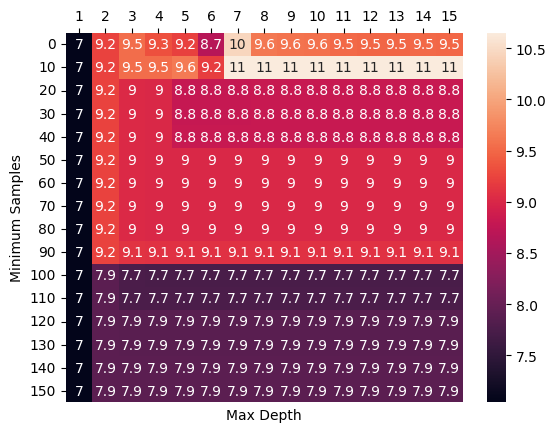

In [75]:
import seaborn as sns
ax = sns.heatmap(plot_df0, annot=True)
ax.xaxis.tick_top()
ax.set(ylabel="Minimum Samples", xlabel="Max Depth")